# Compute Drone Path

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [7]:
# input file
data_32 = "../Dataset/32Almonds.txt"
data_64 = "../Dataset/64Walnut.txt"
data_128 = "../Dataset/128Hazelnut.txt"
data_128_circle = "../Dataset/128Circle201.txt"
data_256 = "../Dataset/256Cashew.txt"
print(data_32)
print(data_64)
print(data_128)
print(data_128_circle)
print(data_256)

../Dataset/32Almonds.txt
../Dataset/64Walnut.txt
../Dataset/128Hazelnut.txt
../Dataset/128Circle201.txt
../Dataset/256Cashew.txt


In [8]:
# convert txt to csv and read as DataFrame
def text_to_csv(input_file, output_file):
    data = pd.read_csv(input_file, header=None, delim_whitespace=True)
    data.to_csv(output_file, index=False, header=False)
    return pd.read_csv(output_file, header=None)

df_data_32 = text_to_csv(data_32, "../Dataset/32Almonds.csv")
df_data_64 = text_to_csv(data_64, "../Dataset/64Walnut.csv")
df_data_128 = text_to_csv(data_128, "../Dataset/128Hazelnut.csv")
df_data_128_circle = text_to_csv(data_128_circle, "../Dataset/128Circle201.csv")
df_data_256 = text_to_csv(data_256, "../Dataset/256Cashew.csv")

In [9]:
# check if data are clean: should contain all numbers
def check_data(file):
    try:
        df = pd.read_csv(file, header=None)
        df = df.apply(pd.to_numeric)
        print(f"Data in {file} is clean.")
    except ValueError:
        print(f"Data in {file} contains non-numeric values.")

In [10]:
print(df_data_32.head())
print(df_data_64.head())
print(df_data_128.head())
print(df_data_128_circle.head())
print(df_data_256.head())

           0          1
0  50.002244  80.033058
1  47.992214  45.379771
2  90.472224  43.239150
3  60.986665  82.531380
4  61.766639   8.346982
           0          1
0  54.787090  53.086428
1  94.273698  65.444571
2  41.774410  40.761920
3  98.305247  81.998122
4  30.145495  71.835894
           0          1
0   9.111346  92.960887
1  57.620938  69.666720
2  68.336324  58.279097
3  54.659311  81.539721
4  42.572884  87.901390
           0          1
0  82.000000  50.000000
1  81.960845  51.582519
2  81.843477  53.161165
3  81.648183  54.732076
4  81.375440  56.291406
           0          1
0  91.213247  64.206083
1  10.401157  41.904829
2  74.554607  39.076208
3  73.626746  81.614010
4  56.186143  31.742786


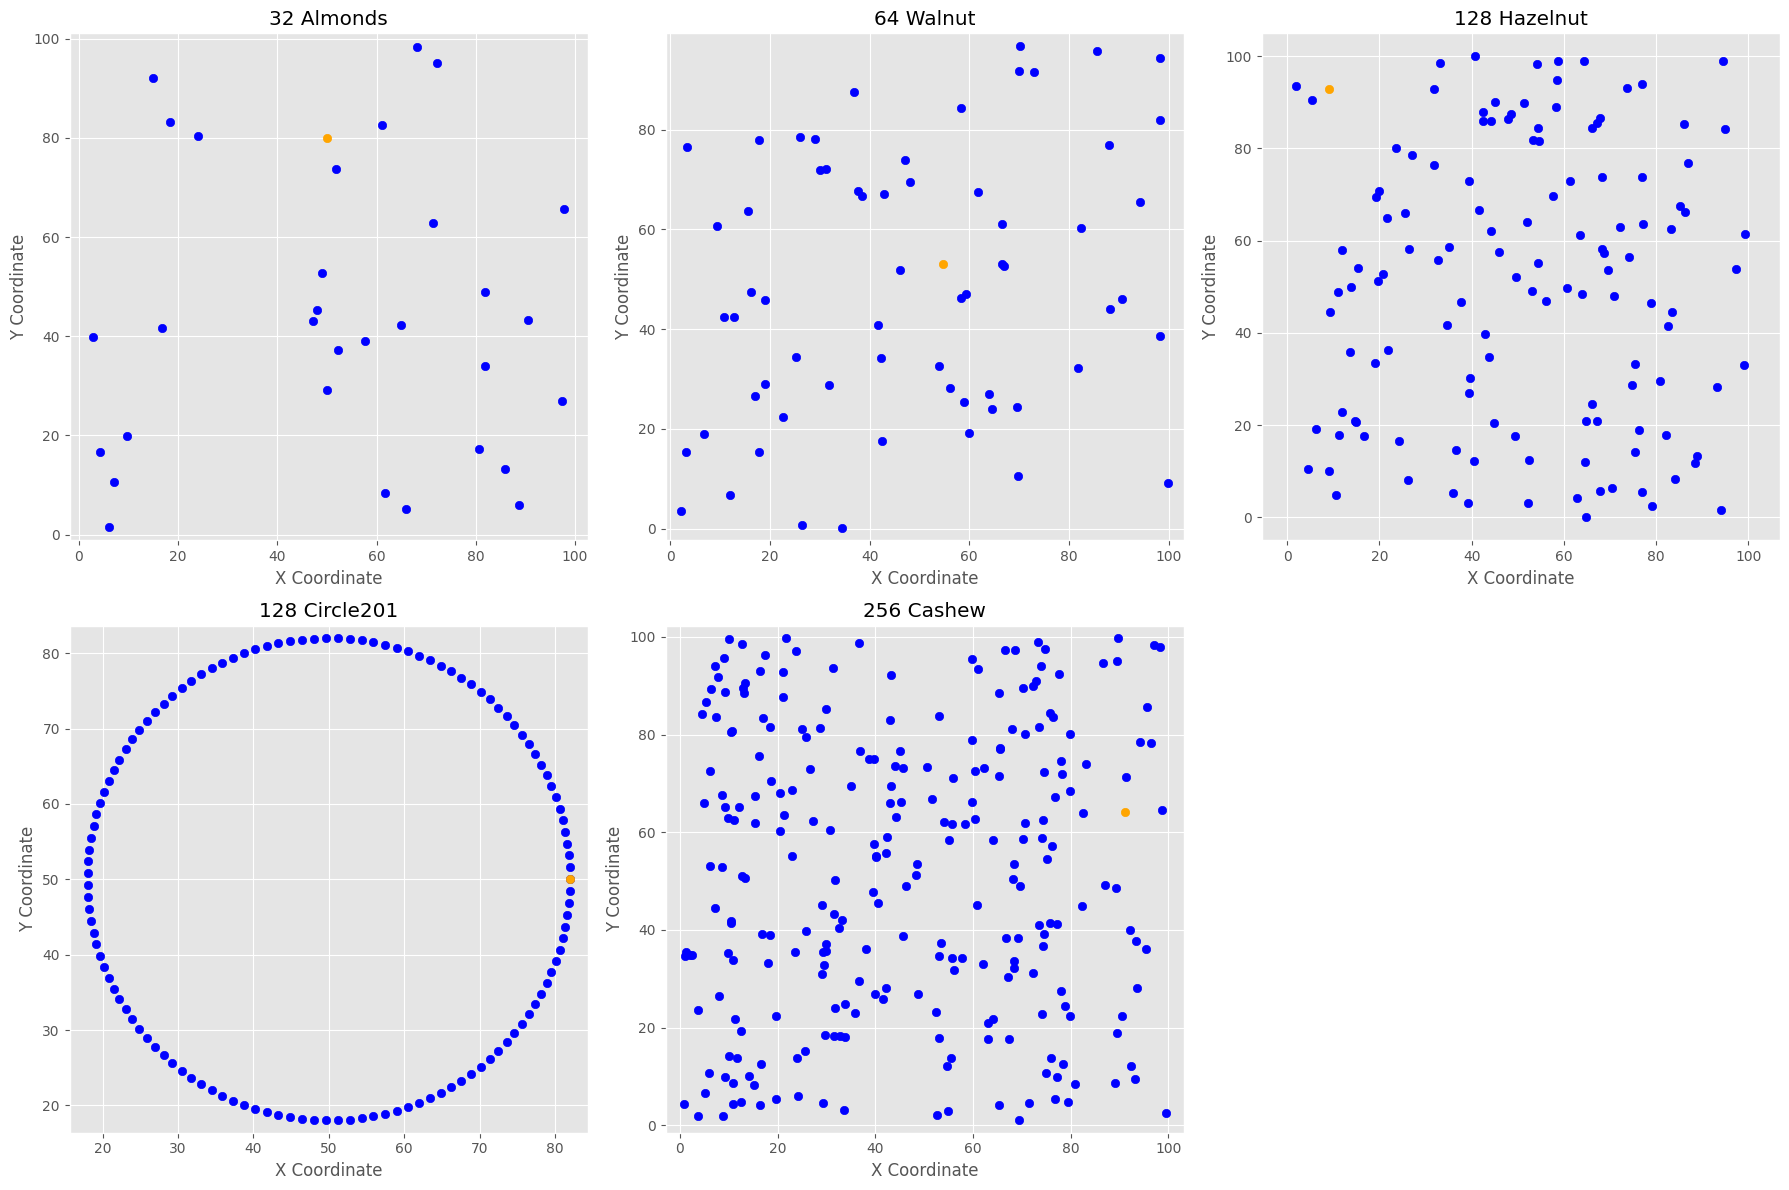

In [11]:
# plot all 5 datasets in a single 3x2 canvas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
datasets = [
    (df_data_32, "32 Almonds"),
    (df_data_64, "64 Walnut"),
    (df_data_128, "128 Hazelnut"),
    (df_data_128_circle, "128 Circle201"),
    (df_data_256, "256 Cashew")
]

for idx, (df, title) in enumerate(datasets):
    ax = axes[idx // 3, idx % 3]
    # Plot all points except the first in blue
    ax.scatter(df[0][1:], df[1][1:], c='blue', marker='o')
    # Plot the first point in orange
    ax.scatter(df[0][0], df[1][0], c='orange', marker='o')
    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.axis('equal')
    ax.grid(True)

# Hide the last (empty) subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

---

In [12]:
# apply k means on df_data_32
def apply_kmeans_and_plot(df, title=None, base_color="orange", base_label="Drone Base"):
    points = df[[0, 1]].values
    depot_xy = points[0]               # first row is the depot
    X = points[1:]                     # <-- cluster only blue points
    k = max(1, len(X) // 14)

    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=k, random_state=1).fit(X)
    labels = km.labels_

    df["Cluster"] = -1                 # mark depot as -1
    df.loc[df.index[1:], "Cluster"] = labels

    # plot (unchanged)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 6))
    for c in range(k):
        p = df[df["Cluster"] == c]
        plt.scatter(p[0], p[1], label=f"Cluster {c}")
    plt.scatter(depot_xy[0], depot_xy[1], color=base_color, s=100, label=base_label)
    if title: plt.title(title)
    plt.show()


# Example usage:
# apply_kmeans_and_plot(df_data_32, title="K-Means Clustering of 32 Almonds")


In [13]:
from scipy.spatial.distance import cdist

def compute_cluster_links(df, cluster_route_order):
    cluster_links = []
    for i in range(len(cluster_route_order) - 1):
        A = cluster_route_order[i]
        B = cluster_route_order[i + 1]
        a_points = df[df["Cluster"] == A][["X", "Y"]].values
        b_points = df[df["Cluster"] == B][["X", "Y"]].values
        if len(a_points) == 0 or len(b_points) == 0:
            print(f"Cluster {A} or {B} is empty, skipping.")
            continue
        distances = cdist(a_points, b_points)
        idx_a, idx_b = np.unravel_index(np.argmin(distances), distances.shape)
        exit_point_A = a_points[idx_a]
        entry_point_B = b_points[idx_b]
        cluster_links.append({
            "from": A,
            "to": B,
            "exit_point": exit_point_A,
            "entry_point": entry_point_B
        })
    return cluster_links

# Example usage:
# cluster_links = compute_cluster_links(df_data_32, cluster_route_order)
# for link in cluster_links:
#     print(f"From Cluster {link['from']} to Cluster {link['to']}:")
#     print(f"  Exit point: {link['exit_point']}")
#     print(f"  Entry point: {link['entry_point']}")

In [14]:
def entry_exit_map(links, cluster_order, depot_xy=None):
    """
    Build a per-cluster dictionary of entry/exit points
    using the link results and (optional) depot coordinates.
    """
    anchors = {c: {"entry": None, "exit": None} for c in cluster_order}

    for link in links:
        anchors[link["from"]]["exit"] = link["exit_point"]
        anchors[link["to"]]["entry"] = link["entry_point"]

    # first cluster starts at depot, last returns to depot
    if depot_xy is not None:
        anchors[cluster_order[0]]["entry"] = list(depot_xy)
        anchors[cluster_order[-1]]["exit"] = list(depot_xy)

    return anchors

def tsp_path_dp(points, start_idx, end_idx):
    n = len(points)
    dist = cdist(points, points)
    FULL = (1 << n)

    # dp[mask][i] = best cost to reach i having visited 'mask', with start fixed
    dp = np.full((FULL, n), np.inf)
    parent = np.full((FULL, n), -1, dtype=int)

    dp[1 << start_idx][start_idx] = 0.0

    for mask in range(FULL):
        if not (mask & (1 << start_idx)):
            continue
        for u in range(n):
            if not (mask & (1 << u)):
                continue
            cur = dp[mask][u]
            if not np.isfinite(cur):
                continue
            for v in range(n):
                if mask & (1 << v):  # already visited
                    continue
                nm = mask | (1 << v)
                cand = cur + dist[u, v]
                if cand < dp[nm][v]:
                    dp[nm][v] = cand
                    parent[nm][v] = u

    # finish at end_idx (no return to start)
    full = FULL - 1
    cost = dp[full][end_idx]

    # reconstruct path end_idx -> start_idx
    path = []
    mask = full
    last = end_idx
    while last != -1:
        path.append(last)
        prv = parent[mask][last]
        if prv == -1:
            break
        mask ^= (1 << last)
        last = prv

    path.reverse()  # start -> ... -> end
    return path, float(cost)


In [15]:
def solve_cluster_route_path(points_xy, entry_xy, exit_xy, atol=1e-9):
    """
    Solve a fixed-start/fixed-end TSP path inside one cluster.
    Ensures entry/exit exist exactly once; keeps all original cluster points.
    """
    pts = np.array(points_xy, dtype=float, copy=True)

    # helper to test if a point already exists in pts
    def has_point(p):
        return np.any(np.all(np.isclose(pts, p, atol=atol), axis=1))

    # append entry/exit only if missing (avoid duplicates; don't drop any originals)
    if not has_point(entry_xy):
            print("Entry not in cluster, adding:", entry_xy)
            pts = np.vstack([pts, entry_xy])
    if not has_point(exit_xy):
        print("Exit not in cluster, adding:", exit_xy)
        pts = np.vstack([pts, exit_xy])

    # find indices for fixed endpoints
    start_idx = np.where(np.all(np.isclose(pts, entry_xy, atol=atol), axis=1))[0][0]
    end_idx   = np.where(np.all(np.isclose(pts, exit_xy,  atol=atol), axis=1))[0][0]

    order, _ = tsp_path_dp(pts, start_idx, end_idx)  # your path-DP
    
    assert len(order) == len(pts), f"Cluster path missed nodes: {len(order)} < {len(pts)}"
    return pts[order]


def same_point(a, b):
    return a[0] == b[0] and a[1] == b[1]


def stitch_full_route(df, cluster_order, anchors, cluster_col="Cluster", xy_cols=(0,1)):
    depot = np.array(anchors[cluster_order[0]]["entry"], dtype=float)
    full = []   # we will start with the first subroute (which starts at depot)

    for idx, c in enumerate(cluster_order):
        pts   = df[df[cluster_col] == c].loc[:, xy_cols].to_numpy(dtype=float)
        entry = np.array(anchors[c]["entry"], dtype=float)
        exit_ = np.array(anchors[c]["exit"],  dtype=float)

        sub = solve_cluster_route_path(pts, entry, exit_)   # returns entry→…→exit

        if not full:
            full.extend(sub)                     # sub[0] should be depot for first cluster
        else:
            # only skip if it is EXACTLY the same point (avoid dropping real nodes)
            if same_point(full[-1], sub[0]):
                full.extend(sub[1:])
            else:
                full.extend(sub)

    # ensure closed tour: start at depot and end at depot
    if not same_point(full[0], depot):
        full.insert(0, depot)
    full.append(depot)  # 强制最后再加一次 depot

    return np.array(full, dtype=float)


def route_length(route_xy):
    return float(np.sum(np.linalg.norm(route_xy[1:] - route_xy[:-1], axis=1)))

In [16]:
# now we get exit point and entry point between clusters. 
# the first and last point is also orange point (drone base)
# run dynamic programming TSP on these points to get the order of clusters

def tsp_dynamic_programming(points):
    n = len(points)
    # print(n)
    all_visited = (1 << n) - 1
    dist = cdist(points, points)

    # dp[mask][i] = minimum cost to visit all nodes in mask ending at node i
    dp = np.full((1 << n, n), np.inf)
    dp[1][0] = 0  # start at node 0

    for mask in range(1 << n):
        for u in range(n):
            if mask & (1 << u):
                for v in range(n):
                    if not (mask & (1 << v)):
                        new_mask = mask | (1 << v)
                        dp[new_mask][v] = min(dp[new_mask][v], dp[mask][u] + dist[u][v])

    full_mask = (1 << n) - 1
    min_cost = np.inf
    last_node = -1
    for i in range(1, n):
        cost = dp[full_mask][i] + dist[i][0]  # <-- return to start
        if cost < min_cost:
            min_cost = cost
            last_node = i
            
    # Reconstruct the path
    path = []
    mask = all_visited
    while last_node != -1:
        path.append(last_node)
        next_node = -1
        for i in range(n):
            if mask & (1 << i) and i != last_node:
                if dp[mask][last_node] == dp[mask ^ (1 << last_node)][i] + dist[i][last_node]:
                    next_node = i
                    break
        mask ^= (1 << last_node)
        last_node = next_node

    return path[::-1], min_cost


In [17]:
def get_cluster_visit_order(centroids, depot_xy=None):
    """
    Solve a small TSP (DP) over cluster centroids.
    Returns the best visiting order (without the depot).
    """
    if depot_xy is not None:
        points = np.vstack([depot_xy, centroids])
    else:
        points = centroids

    order, _ = tsp_dynamic_programming(points)
    # remove depot index 0
    cluster_order = [i-1 for i in order if i != 0]
    return cluster_order


---

128 Circle

In [18]:
# # now we have the function. now use dataset df_data_128_circie
# # apply function, and compute the cost
# apply_kmeans_and_plot(df_data_128_circle, title="K-Means Clustering of 128 Circle201")

In [19]:
# print out number of clusters
# print("Number of clusters in 128 Circle201:", df_data_128_circle["Cluster"].nunique())

In [20]:
# # df has columns ["X","Y","Cluster"] (rename if needed)
# # Ensure columns are named "X" and "Y" for centroid calculation
# df = df_data_128_circle.rename(columns={0: "X", 1: "Y"})
# centroids = (
#     df[df["Cluster"] != -1]                 # <-- exclude depot
#       .groupby("Cluster")[["X", "Y"]]
#       .mean()
#       .sort_index()
#       .to_numpy()
# )
# print("centroids shape:", centroids.shape)   # for 128Circle201 expect (8, 2)


# order_128_circle = get_cluster_visit_order(centroids)
# print("Cluster visiting order for 128 Circle201:", order_128_circle)

In [21]:
# cluster_link_128_circle = compute_cluster_links(df_data_128_circle, order_128_circle)
# for link in cluster_link_128_circle:
#     print(f"From Cluster {link['from']} to Cluster {link['to']}:")
#     print(f"  Exit point: {link['exit_point']}")
#     print(f"  Entry point: {link['entry_point']}")

In [22]:
# # apply dynamic programming TSP on these points to get the order of clusters
# # prepare points for TSP: start with drone base, then exit/entry points between clusters

# depot_xy = df_data_128_circle.iloc[0, [0, 1]].values
# cluster_order_128_circle = get_cluster_visit_order(centroids, depot_xy=depot_xy)

# cluster_links_128_circle = compute_cluster_links(df_data_128_circle, cluster_order_128_circle)
# anchors_128_circle = entry_exit_map(cluster_links_128_circle, cluster_order_128_circle, depot_xy=depot_xy)

# final_route_xy = stitch_full_route(df_data_128_circle, cluster_order_128_circle, anchors_128_circle)
# total_len = route_length(final_route_xy)

# # depot_xy = df_data_128_circle.iloc[0, [0, 1]].to_numpy()
# # def same_point(a, b): return a[0]==b[0] and a[1]==b[1]

# # print("starts at depot? ", same_point(final_route_xy[0],  depot_xy))
# # print("ends   at depot? ", same_point(final_route_xy[-1], depot_xy))
# # print("len(full route): ", len(final_route_xy))



# all_pts   = set(map(tuple, df_data_128_circle[[0,1]].to_numpy()))
# route_pts = set(map(tuple, final_route_xy[:-1]))       # exclude final depot
# print("Missing:", all_pts - route_pts)                 # should be empty
# print("Unexpected:", route_pts - all_pts)              # should be empty


# # sanity checks
# print("Total points incl. depot twice:", len(final_route_xy))                 # expect 130
# print("Unique points (excluding final depot):", len(np.unique(final_route_xy[:-1], axis=0)))  # expect 128
# print("Total length (no ceiling):", total_len)                                # ≈ 200–202


In [23]:
# final_route_xy = stitch_full_route(df_data_128_circle, cluster_order_128_circle, anchors_128_circle)
# total_len = route_length(final_route_xy)  # must include last edge (depot back to start)

# # sets to confirm coverage (exclude last depot)
# all_pts   = set(map(tuple, df_data_128_circle[[0,1]].to_numpy()))
# route_pts = set(map(tuple, final_route_xy[:-1]))
# print("Missing:", all_pts - route_pts)      # expect set()
# print("Unexpected:", route_pts - all_pts)   # expect set()

# print("Total points incl. depot twice:", len(final_route_xy))                   # expect 129 (128 rows, depot used twice)
# print("Unique points (excluding final depot):", len(set(map(tuple, final_route_xy[:-1]))))  # expect 128
# print("Total length (no ceiling):", total_len)                                  # ≈ 200–202 for Circle201


In [24]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(5, 5))
# plt.plot(final_route_xy[:, 0], final_route_xy[:, 1], '-o', label='Drone Path')
# plt.scatter(final_route_xy[0, 0], final_route_xy[0, 1], color='orange', s=100, label='Depot (Start/End)')
# plt.title('Final Drone Route')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.axis('equal')
# plt.grid(True)
# plt.show()

---

128

In [25]:
# apply_kmeans_and_plot(df_data_128, title="K-Means Clustering of 128 Hazelnut")

In [26]:
# print("Number of clusters in 128 Hazelnut:", df_data_128["Cluster"].nunique())

In [27]:
# df = df_data_128.rename(columns={0: "X", 1: "Y"})

# centroids = (
#     df[df["Cluster"] != -1]                 # <-- exclude depot
#       .groupby("Cluster")[["X", "Y"]]
#       .mean()
#       .sort_index()
#       .to_numpy()
# )
# print("centroids shape:", centroids.shape)   # for 128Circle201 expect (8, 2)


# order_128 = get_cluster_visit_order(centroids)
# print("Cluster visiting order for 128 Hazelnut:", order_128)

In [28]:
# cluster_link_128 = compute_cluster_links(df_data_128, order_128)
# for link in cluster_link_128:
#     print(f"From Cluster {link['from']} to Cluster {link['to']}:")
#     print(f"  Exit point: {link['exit_point']}")
#     print(f"  Entry point: {link['entry_point']}")

In [29]:
# # apply dynamic programming TSP on these points to get the order of clusters
# # prepare points for TSP: start with drone base, then exit/entry points between clusters
# depot_xy = df_data_128.iloc[0, [0, 1]].values
# cluster_order_128 = get_cluster_visit_order(centroids, depot_xy=depot_xy)
# cluster_links_128 = compute_cluster_links(df_data_128, cluster_order_128)
# anchors_128 = entry_exit_map(cluster_links_128, cluster_order_128, depot_xy=depot_xy)
# final_route_xy_128 = stitch_full_route(df_data_128, cluster_order_128, anchors_128)

# all_pts   = set(map(tuple, df_data_128[[0,1]].to_numpy()))
# route_pts = set(map(tuple, final_route_xy_128[:-1]))       # exclude final depot
# print("Missing:", all_pts - route_pts)                 # should be empty
# print("Unexpected:", route_pts - all_pts)              # should be empty

# print("Total points incl. depot twice:", len(final_route_xy_128))                 # expect 130
# print("Unique points (excluding final depot):", len(np.unique(final_route_xy_128[:-1], axis=0)))  # expect 128
# print("Total length (no ceiling):", total_len)     

In [30]:
# # plot final route
# plt.figure(figsize=(5, 5))
# plt.plot(final_route_xy_128[:, 0], final_route_xy_128[:, 1], '-o', label='Drone Path')
# plt.scatter(final_route_xy_128[0, 0], final_route_xy_128[0, 1], color='orange', s=100, label='Depot (Start/End)')
# plt.title('Final Drone Route')
# plt.xlabel('X')
# plt.ylabel('Y')
# # plt.legend()
# plt.axis('equal')
# plt.grid(True)
# plt.show()

---

all in function

In [31]:
def final_route_xy(df):
    
    apply_kmeans_and_plot(df, title=f"K-Means Clustering {df}", base_color="orange", base_label="Drone Base")
    print(f"Number of clusters:", df["Cluster"].nunique())
    
    if 0 in df.columns and 1 in df.columns:
        df = df.rename(columns={0: "X", 1: "Y"})
    centroids = (
        df[df["Cluster"] != -1]
          .groupby("Cluster")[["X", "Y"]]
          .mean()
          .sort_index()
          .to_numpy()
    )
    print("centroids shape:", centroids.shape)
    
    order = get_cluster_visit_order(centroids)
    print("Cluster visiting order:", order)
    
    cluster_link = compute_cluster_links(df, order)
    for link in cluster_link:
        print(f"From Cluster {link['from']} to Cluster {link['to']}:")
        print(f"  Exit point: {link['exit_point']}")
        print(f"  Entry point: {link['entry_point']}")
    
    depot_xy = df.iloc[0][["X", "Y"]].values
    cluster_order = get_cluster_visit_order(centroids, depot_xy=depot_xy)
    cluster_links = compute_cluster_links(df, cluster_order)
    anchors = entry_exit_map(cluster_links, cluster_order, depot_xy=depot_xy)
    final_route_xy = stitch_full_route(df, cluster_order, anchors, xy_cols=("X", "Y"))
    total_len = route_length(final_route_xy)
    
    print("Total points incl. depot twice:", len(final_route_xy))
    print("Unique points (excluding final depot):", len(np.unique(final_route_xy[:-1], axis=0)))
    print("Total length (no ceiling):", total_len)
    
    return final_route_xy, total_len

def plot_final_route(route_xy):

    plt.figure(figsize=(5, 5))
    plt.plot(route_xy[:, 0], route_xy[:, 1], '-o', label='Drone Path')
    plt.scatter(route_xy[0, 0], route_xy[0, 1], color='orange', s=100, label='Depot (Start/End)')
    plt.title('Final Drone Route')
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

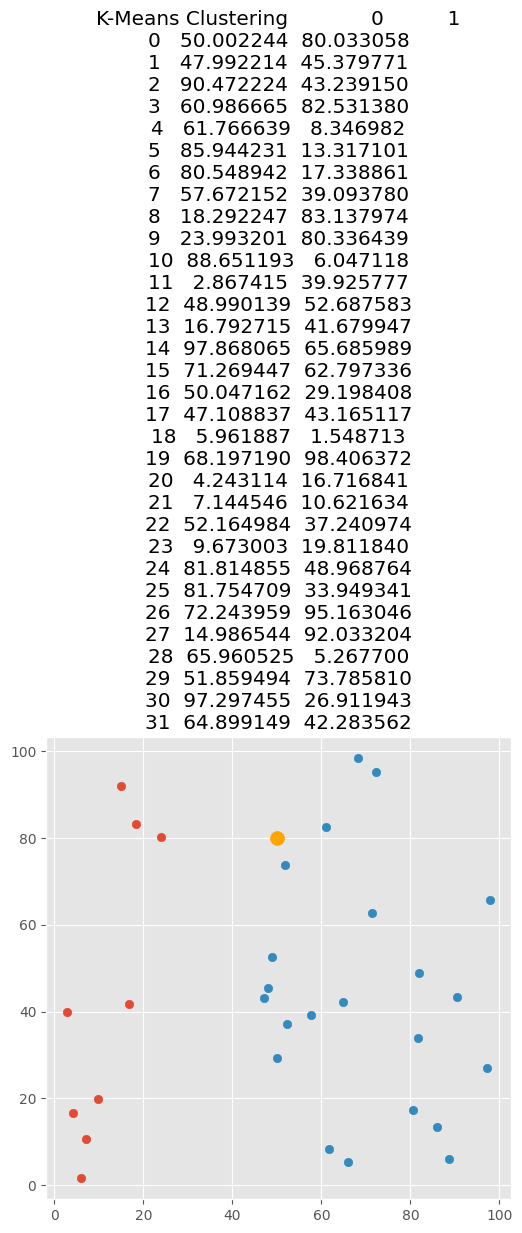

Number of clusters: 3
centroids shape: (2, 2)
Cluster visiting order: [0]
Entry not in cluster, adding: [50.002244 80.033058]
Exit not in cluster, adding: [50.002244 80.033058]
Total points incl. depot twice: 34
Unique points (excluding final depot): 32
Total length (no ceiling): 541.2958532281853


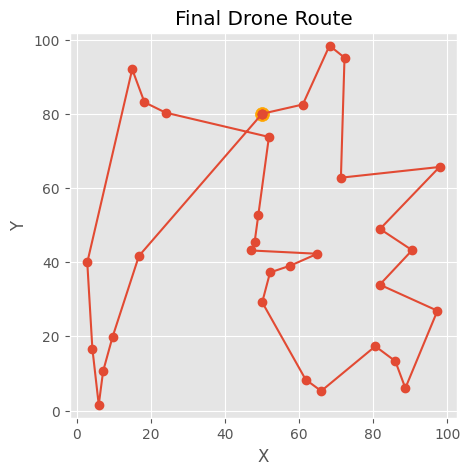

In [32]:
final_route_32, total_len_32 = final_route_xy(df_data_32)
plot_final_route(final_route_32)

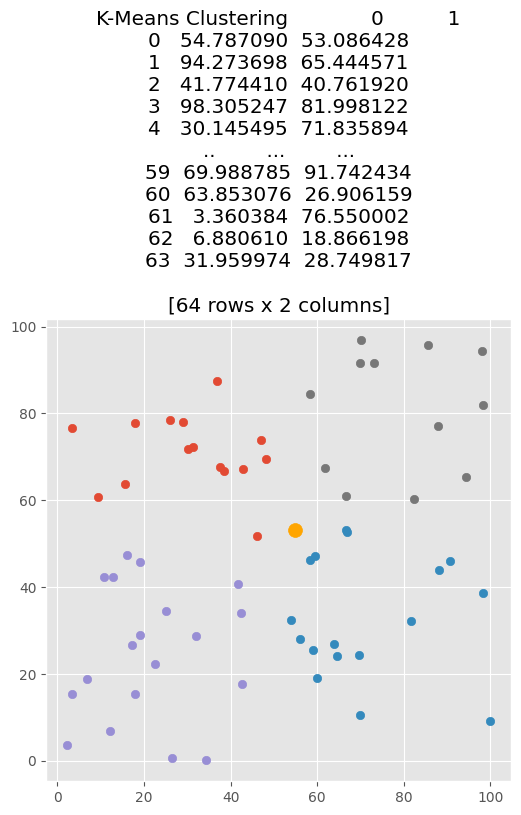

Number of clusters: 5
centroids shape: (4, 2)
Cluster visiting order: [2, 0, 1]
From Cluster 2 to Cluster 0:
  Exit point: [41.77441 40.76192]
  Entry point: [46.072594 51.805211]
From Cluster 0 to Cluster 1:
  Exit point: [46.072594 51.805211]
  Entry point: [58.406933 46.244916]
Entry not in cluster, adding: [54.78709  53.086428]
Exit not in cluster, adding: [54.78709  53.086428]
Total points incl. depot twice: 66
Unique points (excluding final depot): 64
Total length (no ceiling): 673.0208829161088


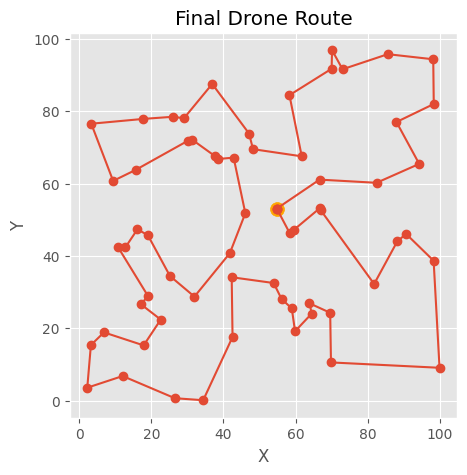

In [33]:
final_route_64, total_len_64 = final_route_xy(df_data_64)
plot_final_route(final_route_64)

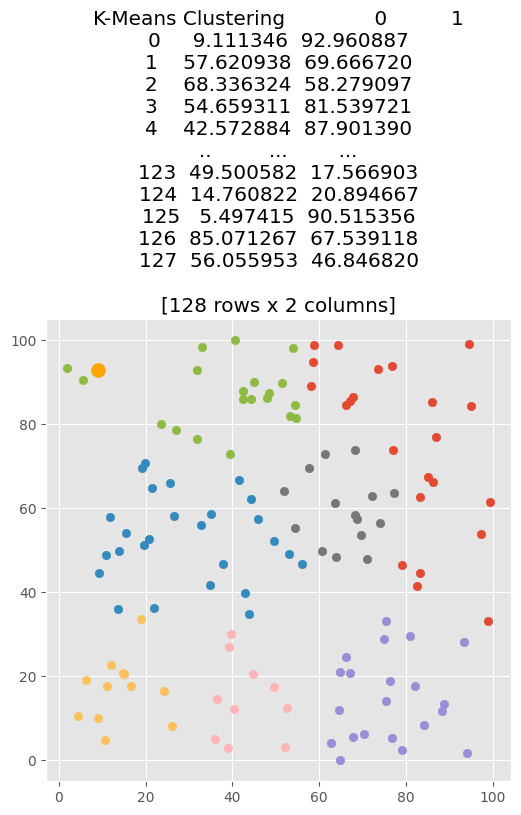

Number of clusters: 10
centroids shape: (9, 2)
Cluster visiting order: [2, 6, 4, 0, 7, 3, 5, 1]
From Cluster 2 to Cluster 6:
  Exit point: [62.789638   4.2652411]
  Entry point: [52.249531   3.1991016]
From Cluster 6 to Cluster 4:
  Exit point: [35.922821  5.207789]
  Entry point: [26.214532   8.2071207]
From Cluster 4 to Cluster 0:
  Exit point: [18.971041 33.584897]
  Entry point: [78.996303 46.483994]
From Cluster 0 to Cluster 7:
  Exit point: [85.071267 67.539118]
  Entry point: [86.994103 76.902909]
From Cluster 7 to Cluster 3:
  Exit point: [77.028551 73.864029]
  Entry point: [68.341587 73.784165]
From Cluster 3 to Cluster 5:
  Exit point: [61.346074 72.975186]
  Entry point: [54.659311 81.539721]
From Cluster 5 to Cluster 1:
  Exit point: [39.470748 72.866168]
  Entry point: [41.615859 66.641622]
Entry not in cluster, adding: [ 9.1113464 92.960887 ]
Exit not in cluster, adding: [ 9.1113464 92.960887 ]
Total points incl. depot twice: 130
Unique points (excluding final depot): 12

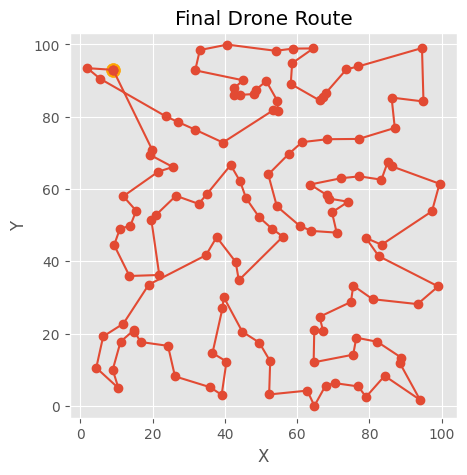

In [34]:
final_route_128, total_len_128 = final_route_xy(df_data_128)
plot_final_route(final_route_128)

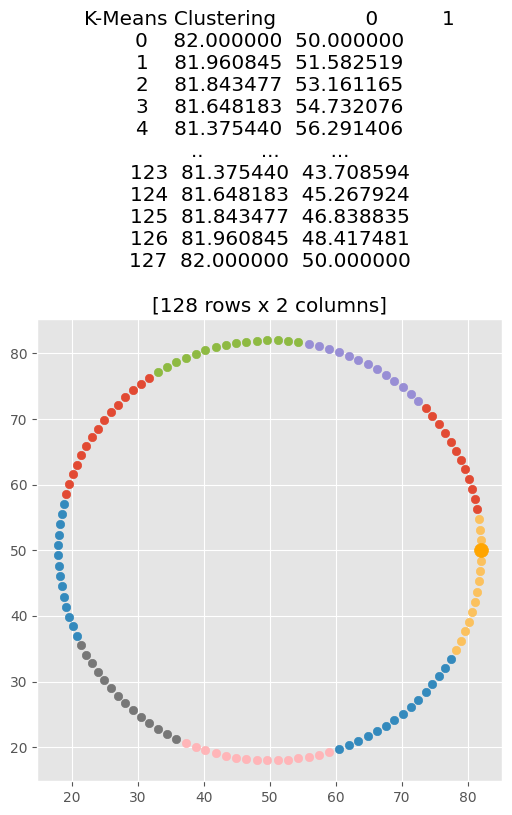

Number of clusters: 10
centroids shape: (9, 2)
Cluster visiting order: [7, 2, 5, 0, 3, 6, 1, 4]
From Cluster 7 to Cluster 2:
  Exit point: [73.585446 71.626991]
  Entry point: [72.487052 72.766917]
From Cluster 2 to Cluster 5:
  Exit point: [55.902868 81.450853]
  Entry point: [54.340284 81.704289]
From Cluster 5 to Cluster 0:
  Exit point: [33.094827 77.170115]
  Entry point: [31.771849 76.300846]
From Cluster 0 to Cluster 3:
  Exit point: [19.177379 58.600351]
  Entry point: [21.469844 35.50758 ]
From Cluster 3 to Cluster 6:
  Exit point: [35.861554 21.292782]
  Entry point: [37.298533 20.628709]
From Cluster 6 to Cluster 1:
  Exit point: [58.980913 19.286107]
  Entry point: [60.48884  19.767828]
From Cluster 1 to Cluster 4:
  Exit point: [77.377122 33.432164]
  Entry point: [78.162965 34.806337]
Exit not in cluster, adding: [82. 50.]
Total points incl. depot twice: 129
Unique points (excluding final depot): 127
Total length (no ceiling): 210.5200800817247


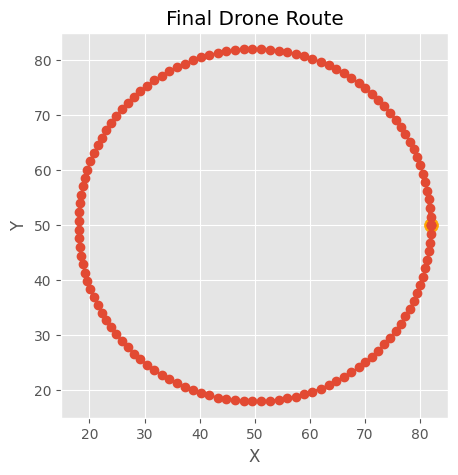

In [35]:
final_route_128_circle, total_len_128_circle = final_route_xy(df_data_128_circle)
plot_final_route(final_route_128_circle)

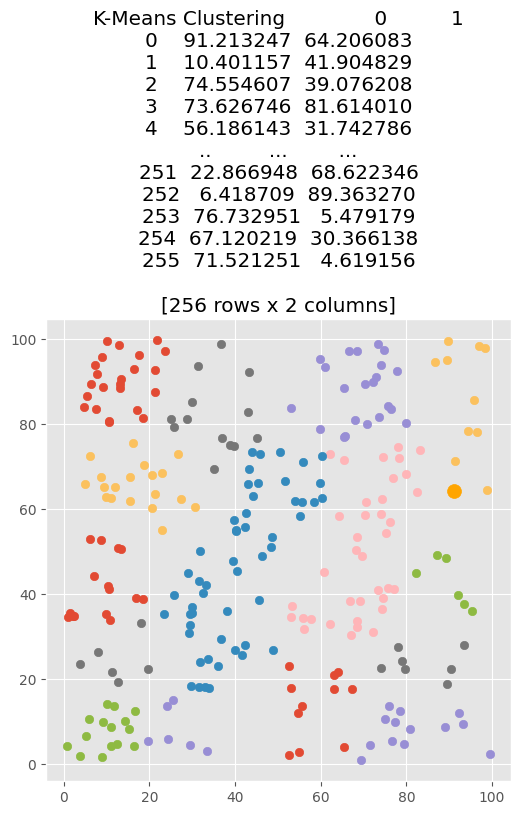

Number of clusters: 19
centroids shape: (18, 2)
Cluster visiting order: [9, 7, 1, 10, 5, 11, 2, 8, 13, 12, 14, 0, 15, 4, 16, 6, 3]
From Cluster 9 to Cluster 7:
  Exit point: [75.932738 13.860172]
  Entry point: [18.443367 39.000491]
From Cluster 7 to Cluster 1:
  Exit point: [18.443367 39.000491]
  Entry point: [31.752058 24.0905  ]
From Cluster 1 to Cluster 10:
  Exit point: [36.765292 29.550725]
  Entry point: [35.077674 69.474323]
From Cluster 10 to Cluster 5:
  Exit point: [35.077674 69.474323]
  Entry point: [16.620356 12.477404]
From Cluster 5 to Cluster 11:
  Exit point: [16.620356 12.477404]
  Entry point: [91.380041 71.357401]
From Cluster 11 to Cluster 2:
  Exit point: [86.693029 94.557919]
  Entry point: [77.724054 92.45809 ]
From Cluster 2 to Cluster 8:
  Exit point: [59.721135 78.907351]
  Entry point: [60.353344 72.610443]
From Cluster 8 to Cluster 13:
  Exit point: [46.326058 48.959434]
  Entry point: [53.377195 37.356381]
From Cluster 13 to Cluster 12:
  Exit point: [77

AssertionError: Cluster path missed nodes: 1 < 17

In [36]:
final_route_256, total_len_256 = final_route_xy(df_data_256)
plot_final_route(final_route_256)

In [ ]:
# print("For 32 Almonds:", total_len_32)
# print("For 64 Almonds:", total_len_64)
# print("For 128 Almonds:", total_len_128)
# print("For 128 Circle Almonds:", total_len_128_circle)
# print("For 256 Almonds:", total_len_256)